This project is an attempt to train a basic chess model using reinforcement learning techniques, using this API for making chess moves: 

https://python-chess.readthedocs.io/en/latest/

In [ ]:
!pip install chess

In [ ]:
import numpy as np
import chess
import tensorflow as tf
import copy
import random
import chess.svg
from IPython.display import SVG, display

In [ ]:
board = chess.Board()
print(board)

r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
P P P P P P P P
R N B Q K B N R


The first thing I will do is create a function to transform the board from the pieces into a readable format for a neural network. I will convert the piece names (pawn, bishop, rook, etc.) into values. 

Notice that from the above board, lower case letters indicate black pieces and upper case letters indicate white pieces. I will create a second matrix containing 0 and 1s to convey this information numerically. 

In order to get the board as a matrix of letters, I used make_matrix() from this [stack overflow post](https://stackoverflow.com/questions/55876336/is-there-a-way-to-convert-a-python-chess-board-into-a-list-of-integers):


In [ ]:
'''
This function is used to convert the board into a matrix of letters 
representing the pieces
'''
def make_matrix(board): #type(board) == chess.Board()
  pgn = board.epd()
  foo = []  #Final board
  pieces = pgn.split(" ", 1)[0]
  rows = pieces.split("/")
  for row in rows:
      foo2 = []  #This is the row I make
      for thing in row:
          if thing.isdigit():
              for i in range(0, int(thing)):
                  foo2.append('.')
          else:
              foo2.append(thing)
      foo.append(foo2)
  return foo

'''
This is the function I wrote myself to convert the pieces to numbers
and 0s and 1s based on their color
'''
def encode_board(board):
  board = make_matrix(board)

  #color_mask = np.zeros((8, 8, 1))
  piece_mask = np.zeros((8, 8, 1))

  for r in range(8):
    for c in range(8):
      # Convert the piece into 0 or 1 or -1 based on neutral, white, or black
      '''
      if board[r][c] in ['P', 'R', 'N', 'B', 'Q', 'K']:
        color_mask[r][c][0] = 1
      elif board[r][c] == '.':
        color_mask[r][c][0] = 0 
      else:
        color_mask[r][c][0] = -1
      '''

      # Convert the piece into number
      piece = board[r][c].lower()
      
      if piece == 'p':
        piece_mask[r][c][0] = 1
      elif piece == 'r':
        piece_mask[r][c][0] = 5
      elif piece == 'n':
        piece_mask[r][c][0] = 3
      elif piece == 'b':
        piece_mask[r][c][0] = 3.25
      elif piece == 'q':
        piece_mask[r][c][0] = 9
      elif piece == 'k':
        piece_mask[r][c][0] = 20
      
      # Multiply the piece by 0 or 1 or -1 based on neutral, white, or black
      if board[r][c] in ['P', 'R', 'N', 'B', 'Q', 'K']:
        piece_mask[r][c][0] *= 1
      elif board[r][c] == '.':
        piece_mask[r][c][0] *= 0 
      else:
        piece_mask[r][c][0] *= -1

  return piece_mask #np.concatenate((color_mask, piece_mask), axis=-1)

The result of calling this function will give us two 8 by 8 matrices. The first matrix will represent the color of the pieces, so that the agent knows which piece belongs to its opponents. The second matrix will represent the value of the pieces so that the agent knows how important that piece is. 

Note that bishops were given a value of 3.25 instead of 3 because:

*   It is debatable that they are better than knights, especially in endgames
*   The model can differentiate the bishop from the knight based on this value



In [ ]:
encode_board(board)[0][5][0]

-3.25

In [ ]:
'''model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(128, activation='relu'))
model.add(tf.keras.layers.LSTM(1))

model.compile(optimizer='RMSprop', loss='mse')'''

"model = tf.keras.Sequential()\nmodel.add(tf.keras.layers.LSTM(128, activation='relu'))\nmodel.add(tf.keras.layers.LSTM(1))\n\nmodel.compile(optimizer='RMSprop', loss='mse')"

In [ ]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(64, 1, activation='relu', padding='same', input_shape=(8, 8, 2)))
# model.add(tf.keras.layers.Conv2D(128, 2, activation='relu', padding='same'))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation=None)) # Output score

model.compile(optimizer='RMSprop', loss='mse')
model.summary()

class Agent():
  def __init__(self, games):
    self.model = model


    self.init_exploration_value = 0.999
    self.final_exploration_value = 0.25
    self.exploration_value = self.init_exploration_value

    self.inputs = dict()
    self.outputs = dict()
    self.move = 0
    self.games = games

  ''' 
  Chooses the best move regardless of the exploration reward
  '''
  def choose_best_move(self, board):
    best_move = None
    best_move_reward = -np.inf
    for move in board.legal_moves:
      board_copy = copy.deepcopy(board)
      board_copy.push(move)
      model_inputs = np.expand_dims(np.concatenate((encode_board(board), encode_board(board_copy)), axis=-1), 0)
      move_reward = model.predict(model_inputs) 
      if move_reward > best_move_reward:
        best_move_reward = move_reward
        best_move = move
    return best_move 

  '''
  Chooses which legal move to try based on the predicted reward and exploration 
  value (if the exploration value is high, then it will choose to "explore" new 
  moves regardless of the reward)
  '''
  def choose_move(self, board):
    if random.random() < self.exploration_value:
      new_board_unenc = copy.deepcopy(board)
      new_board_unenc.push(random.choice(list(board.legal_moves)))
      new_board = encode_board(new_board_unenc)
      combined_board = np.concatenate((encode_board(board), new_board), axis=-1)
      self.inputs[self.move] = combined_board
      self.move += 1
      return new_board_unenc

    board.push(self.choose_best_move(board))
    return board


  '''
  The reward for each move is passed in to this function, and this 
  also propagates backwards so that previous moves are accounted for when 
  determining their future effects'''
  def prop_reward(self, reward, discount, move):
    try:
      self.outputs[move] += (reward * discount)
    except Exception as e:
      self.outputs[move] = (reward * discount)

    if move != 0:
      self.prop_reward(reward, discount * 0.75, move - 1)

  ''' 
  When this function is called, the model parameters are updated
  '''
  def fit_model(self):
    '''
    for n in range(self.move):
      out = 0 
      try: 
        out = self.outputs[n]
      except: 
        pass
    '''
    n = self.move
    starting = self.move - 2
    if starting < 0:
      starting = 0
    for n in range(starting, self.move):
      out = 0 
      try: 
        out = self.outputs[n]
      except: 
        pass
      model.fit(np.expand_dims(self.inputs[n], 0), np.array([out]), verbose=0)
  
  '''
  Delete the memory of the current chess game, to prepare for the next one
  '''
  def clear(self):
    self.inputs = dict()
    self.outputs = dict()
    self.move = 0 

  ''' Decay exploration value after each game '''
  def decay_exploration_value(self):
    self.exploration_value = self.exploration_value - ((self.init_exploration_value - self.final_exploration_value) / self.games)



agent = Agent(3)
agent.choose_move(board)
agent.prop_reward(1, 0.95, 0)
agent.fit_model()
print("Old exploration value:", agent.exploration_value)
agent.decay_exploration_value()
agent.decay_exploration_value()
agent.decay_exploration_value()
print("New exploration value:", agent.exploration_value)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 8, 8, 64)          192       
_________________________________________________________________
flatten_2 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               524416    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 524,737
Trainable params: 524,737
Non-trainable params: 0
_________________________________________________________________
Old exploration value: 0.999
New exploration value: 0.24999999999999992


In [ ]:
'''
Calculates white's material relative to black
'''
def get_material(board):
  material_count = 0 

  mat = encode_board(board)
  for r in range(8):
    for c in range(8):
      material_count += mat[r][c][0]
      '''
      if mat[r][c][0] == 0:
        continue
      elif mat[r][c][0] == -1: # If it's -1 or lowercase, then it is a black piece
        material_count -= mat[r][c][1]
      elif mat[r][c][0] == 1: # Otherwise it is a white piece
        material_count += mat[r][c][1]
      '''
  return material_count

In [ ]:
board = chess.Board()
print(get_material(board))

0.0


In [ ]:
games = 50

for game in range(games):
  turn = 0 
  white_agent = Agent(games)
  
  board = chess.Board()
  while not board.is_game_over():
    if turn % 2 == 0:
      initial_mat = get_material(board)
      board = white_agent.choose_move(board)
      after_mat = get_material(board)
      reward = after_mat - initial_mat
      if reward != 0:
        white_agent.prop_reward(reward, 0.7, (turn + 1) // 2)
    else:
      board.push(random.choice(list(board.legal_moves)))
    white_agent.fit_model()
    turn += 1

  white_reward = None
  if board.result() == '0-1':
      white_reward = -20
  elif board.result() == '1/2-1/2':
      white_reward = 0
  else:
      white_reward = 20

  black_reward = -white_reward

  white_agent.prop_reward(white_reward, 0.95, (turn + 1) // 2)
  white_agent.fit_model()
  white_agent.decay_exploration_value()

  print('Game:', game, 'result:', board.result(), 'disparity:', (white_reward + get_material(board)))

Game: 0 result: 1/2-1/2 disparity: -3.0
Game: 1 result: 1/2-1/2 disparity: 0.0
Game: 2 result: 1-0 disparity: 33.25
Game: 3 result: 1/2-1/2 disparity: 0.0
Game: 4 result: 1/2-1/2 disparity: -3.25
Game: 5 result: 1/2-1/2 disparity: 0.0
Game: 6 result: 1/2-1/2 disparity: 0.0
Game: 7 result: 0-1 disparity: -41.0
Game: 8 result: 1/2-1/2 disparity: -5.0
Game: 9 result: 1/2-1/2 disparity: 19.75
Game: 10 result: 1/2-1/2 disparity: 3.0
Game: 11 result: 1/2-1/2 disparity: -3.25
Game: 12 result: 1/2-1/2 disparity: -3.0
Game: 13 result: 1/2-1/2 disparity: 0.0
Game: 14 result: 1/2-1/2 disparity: -3.0
Game: 15 result: 1/2-1/2 disparity: 0.0
Game: 16 result: 1-0 disparity: 26.75
Game: 17 result: 0-1 disparity: -26.0
Game: 18 result: 1/2-1/2 disparity: 3.0
Game: 19 result: 1-0 disparity: 23.0
Game: 20 result: 1/2-1/2 disparity: -3.25
Game: 21 result: 1/2-1/2 disparity: 11.0
Game: 22 result: 1/2-1/2 disparity: 3.0
Game: 23 result: 1/2-1/2 disparity: -3.0
Game: 24 result: 1/2-1/2 disparity: 0.0
Game: 2

In [ ]:
model.predict(np.zeros(shape=(1, 8, 8, 2))) > 0.49

array([[ True]])

In [ ]:
SVG_list = []

test_games = 1
for test_game in range(test_games):
  turn = 0
  white_agent = Agent(test_game)
  board = chess.Board()

  while not board.is_game_over():
    if turn % 2 == 0:
      best_move = white_agent.choose_best_move(board)
      board.push(best_move)
    else:
      board.push(random.choice(list(board.legal_moves)))
      
    if turn % 20 == 0:
      SVG_list.append(SVG(chess.svg.board(board, size=350)))

    turn += 1

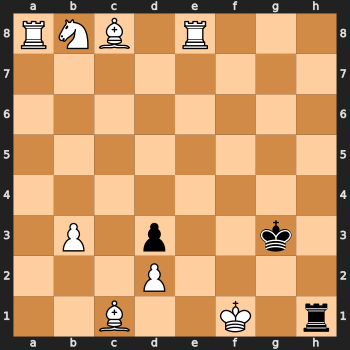

In [ ]:
from IPython.display import SVG, display
display(SVG(chess.svg.board(board, size=350) ))

In [ ]:
get_material(board)

15.5